### Galaxy Zoo - The Galaxy Challenge

#### Authur: Ching-Yin NG
#### Source code and report are available at https://github.com/alvinng4/GalaxyZooChallenge
#### Best model score: 0.07972
#### Best score after model averaging: 0.07716

Q1. Is the object a smooth galaxy, a galaxy with features/disk or a star? 3 responses\
Q2. Is it edge-on? 2 responses\
Q3. Is there a bar? 2 responses\
Q4. Is there a spiral pattern? 2 responses\
Q5. How prominent is the central bulge? 4 responses\
Q6. Is there anything "odd" about the galaxy? 2 responses\
Q7. How round is the smooth galaxy? 3 responses\
Q8. What is the odd feature? 7 responses\
Q9. What shape is the bulge in the edge-on galaxy? 3 responses\
Q10. How tightly wound are the spiral arms? 3 responses\
Q11. How many spiral arms are there? 6 responses

In [1]:
import math
from pathlib import Path
import random
import timeit

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import polars
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

SUBCLASS_LEN = [3, 2, 2, 2, 4, 2, 3, 7, 3, 3, 6]
SUBCLASS_LEN_CUMSUM = np.cumsum(SUBCLASS_LEN)
CLASS_LEN = len(SUBCLASS_LEN)

RANDOM_STATE = 1
torch.manual_seed(RANDOM_STATE)

FILE_PREFIX = "test"
MODEL_DIR = Path(f"models/{FILE_PREFIX}")
IMAGE_DIR = Path("images")

MODEL_DIR.mkdir(parents=True, exist_ok=True)
IMAGE_DIR.mkdir(parents=True, exist_ok=True)

print(torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

True


### Import dataset

In [2]:
data_folder = Path("../data")

img_path = data_folder / "images_training_rev1"
file_list = sorted([str(path) for path in img_path.glob('*.jpg')])
print(f"Number of data: {len(file_list)}")

train_sol_path = data_folder / "training_solutions_rev1" / "training_solutions_rev1.csv"
train_sol = polars.read_csv(train_sol_path)
print("Some labels: ")
print(train_sol.head())

soft_labels = train_sol[:, 1:].to_numpy()

one_hot_labels = np.argmax(soft_labels[:, :SUBCLASS_LEN_CUMSUM[0]], axis=1)    # Class one
for i in range(1, CLASS_LEN):
    one_hot_labels = np.vstack(
        (one_hot_labels, np.argmax(soft_labels[:, SUBCLASS_LEN_CUMSUM[i - 1]:SUBCLASS_LEN_CUMSUM[i]], axis=1))
    )
one_hot_labels = one_hot_labels.T
print(soft_labels)
print(soft_labels.shape)
print(one_hot_labels)
print(one_hot_labels.shape)

Number of data: 61578
Some labels: 
shape: (5, 38)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ GalaxyID ┆ Class1.1 ┆ Class1.2 ┆ Class1.3 ┆ … ┆ Class11.3 ┆ Class11.4 ┆ Class11.5 ┆ Class11.6 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 100008   ┆ 0.383147 ┆ 0.616853 ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.325512  │
│ 100023   ┆ 0.327001 ┆ 0.663777 ┆ 0.009222 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100053   ┆ 0.765717 ┆ 0.177352 ┆ 0.056931 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100078   ┆ 0.693377 ┆ 0.238564 ┆ 0.068059 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100090   ┆ 0.933839 ┆ 0.0      ┆ 0.066161 ┆ … ┆ 0.0       ┆ 0.0  

In [3]:
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        file = self.file_list[index]
        label = self.labels[index]

        image = Image.open(file)

        if self.transform is not None:
            image = self.transform(image)

        return image, label
    
    def __len__(self):
        return len(self.labels)
        
transform_train = transforms.Compose([
    transforms.RandomRotation(360),
    transforms.CenterCrop([256, 256]),
    transforms.Resize([128, 128]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.CenterCrop([256, 256]),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = ImageDataset(file_list, soft_labels, transform_train)
print(f"Length of training files: {len(train_dataset)}")

train_one_hot_labels_class_one = np.argmax(soft_labels[:, :3], axis=1)
print("\nClass 1 distribution: ")
print(f"Training dataset: {Counter(train_one_hot_labels_class_one)}")

Length of training files: 61578

Class 1 distribution: 
Training dataset: Counter({1: 34826, 0: 26693, 2: 59})


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.75686276].
Clipping input data to the val

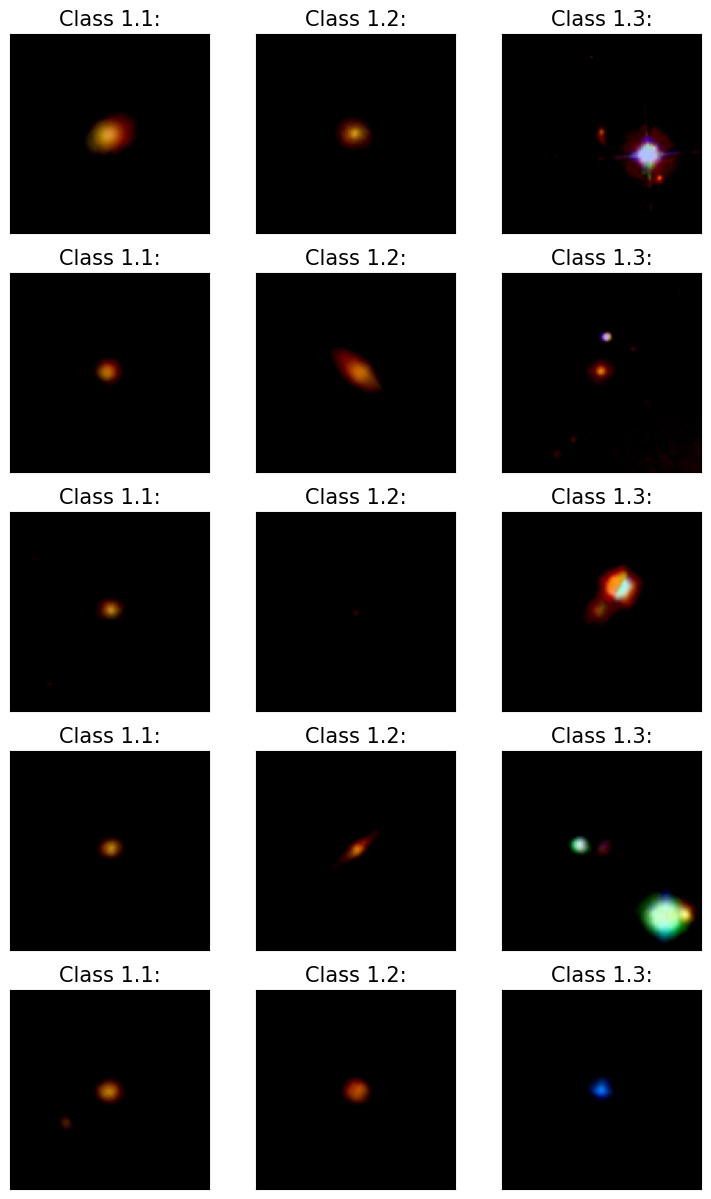

In [4]:
data_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)

img_class_zero = []
img_class_one = []
img_class_two = []
img_per_class = 5

iter_data_loader = iter(data_loader)
while True:
    img_batch, label_batch = next(iter_data_loader)
    for i in range(100):
        img = img_batch[i]
        label = label_batch[i]
        one_hot_label = np.argmax(label[:3])

        if (len(img_class_zero) < img_per_class) and (one_hot_label == 0):
            img_class_zero.append(img)
        elif (len(img_class_one) < img_per_class) and (one_hot_label == 1):
            img_class_one.append(img)
        elif (len(img_class_two) < img_per_class) and (one_hot_label == 2):
            img_class_two.append(img)
            
    if (
        (len(img_class_zero) >= img_per_class)
        and (len(img_class_one) >= img_per_class)
        and (len(img_class_two) >= img_per_class)
    ):
        break

fig1 = plt.figure(figsize=(9, 15))
for i in range(img_per_class):
    img = img_class_zero[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Class 1.1:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_class_one[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Class 1.2:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_class_two[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Class 1.3:', size=15)
    ax.imshow(img.permute(1, 2, 0))

plt.show()

### Create a CNN-CBAM model

In [5]:
class channel_attention(nn.Module):
    def __init__(self, in_channels, reduction_ratio):
        super().__init__()
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        hidden_layer_size = int(in_channels // reduction_ratio)

        self.mlp = nn.Sequential()
        self.mlp.add_module("fc1", nn.Linear(in_channels, hidden_layer_size))
        self.mlp.add_module("relu", nn.ReLU())
        self.mlp.add_module("fc2", nn.Linear(hidden_layer_size, in_channels))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_pooled_map = self.max_pool(x)
        avg_pooled_map = self.avg_pool(x)

        max_att_map = self.mlp(self.flatten(max_pooled_map))
        avg_att_map = self.mlp(self.flatten(avg_pooled_map))

        cha_att_map = self.sigmoid(max_att_map + avg_att_map).unsqueeze(2).unsqueeze(3)

        return cha_att_map

class spatial_attention(nn.Module):
    def __init__(self, in_channels, kernel_size):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=kernel_size, padding=((kernel_size - 1) // 2))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_pooled_map = torch.amax(x, dim=1, keepdim=True)
        avg_pooled_map = torch.mean(x, dim=1, keepdim=True)

        concat_pooled_map = torch.cat((max_pooled_map, avg_pooled_map), dim=1)
        conv_map = self.conv(concat_pooled_map)
        spa_att_map = self.sigmoid(conv_map)

        return spa_att_map

class CBAM(nn.Module):
    def __init__(self, in_channels, cha_att_reduction_ratio, spa_att_kernel_size):
        super().__init__()
        self.channel_attention_module = channel_attention(
            in_channels, cha_att_reduction_ratio
        )
        self.spatial_attention_module = spatial_attention(
            in_channels, spa_att_kernel_size
        )

    def forward(self, x):
        cha_att_map = self.channel_attention_module(x)
        spa_att_map = self.spatial_attention_module(x * cha_att_map)

        return x + (x * cha_att_map * spa_att_map)

In [6]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=17, padding=8))
model.add_module('bn1', nn.BatchNorm2d(num_features=32))
model.add_module('relu1', nn.ReLU())       
model.add_module('cbam1', CBAM(in_channels=32, cha_att_reduction_ratio=1, spa_att_kernel_size=7))
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  
# model.add_module('dropout1', nn.Dropout2d(p=0.15))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=13, padding=6))
model.add_module('bn2', nn.BatchNorm2d(num_features=64))
model.add_module('relu2', nn.ReLU())        
model.add_module('cbam2', CBAM(in_channels=64, cha_att_reduction_ratio=1, spa_att_kernel_size=7))
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
# model.add_module('dropout2', nn.Dropout2d(p=0.15))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=9, padding=4))
model.add_module('bn3', nn.BatchNorm2d(num_features=128))
model.add_module('relu3', nn.ReLU())        
model.add_module('cbam3', CBAM(in_channels=128, cha_att_reduction_ratio=1, spa_att_kernel_size=7))
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
# model.add_module('dropout3', nn.Dropout2d(p=0.15))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7, padding=3))
model.add_module('bn4', nn.BatchNorm2d(num_features=256))
model.add_module('relu4', nn.ReLU())
model.add_module('cbam4', CBAM(in_channels=256, cha_att_reduction_ratio=1, spa_att_kernel_size=7))

In [7]:
x = torch.ones((4, 3, 128, 128))
print(model(x).shape)

torch.Size([4, 256, 16, 16])


In [8]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=2)) 
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, 128, 128))
print(model(x).shape)

torch.Size([4, 16384])


In [9]:
model.add_module('fc1', nn.Linear(16384, 1024)) 
# model.add_module('bn5', nn.BatchNorm1d(num_features=1024))
# model.add_module('dropout4', nn.Dropout(p=0.2))

x = torch.ones((4, 3, 128, 128))
print(model(x).shape)

torch.Size([4, 1024])


In [10]:
model.add_module('fc2', nn.Linear(1024, SUBCLASS_LEN_CUMSUM[-1]))
model.add_module('sigmoid', nn.Sigmoid())

x = torch.ones((4, 3, 128, 128))
print(model(x).shape)

torch.Size([4, 37])


In [11]:
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(17, 17), stride=(1, 1), padding=(8, 8))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (cbam1): CBAM(
    (channel_attention_module): channel_attention(
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (mlp): Sequential(
        (fc1): Linear(in_features=32, out_features=32, bias=True)
        (relu): ReLU()
        (fc2): Linear(in_features=32, out_features=32, bias=True)
      )
      (sigmoid): Sigmoid()
    )
    (spatial_attention_module): spatial_attention(
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (sigmoid): Sigmoid()
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6))
  (bn2): BatchNorm2d(64, eps=1e

In [12]:
model = model.to(device)

### Training the model

In [13]:
hist = [[], []]
lr_hist = []

In [14]:
from sklearn.metrics import mean_squared_error

def train(model, num_epochs, lr_scheduler, optimizer, train_dl, batch_size, hist, lr_hist, save_every_n_epochs):
    loss_fn = nn.BCELoss()
    previous_epochs = len(hist[0])
    
    for epoch in range(num_epochs):
        start = timeit.default_timer()
        model.train()
        i = 0
        loss_hist_train = 0
        rmse_hist_train = 0
        for x_batch, y_batch in train_dl:
            i += 1
            if i % 5 == 0:
                print(f"Progress: epoch: {previous_epochs + epoch + 1}/{previous_epochs + num_epochs}, batch: {i}/{len(train_dl)}", end="\r")
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred.float(), y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train += loss.item() * y_batch.size(0)
            rmse_hist_train += mean_squared_error(y_true=y_batch.cpu(), y_pred=pred.detach().cpu())

        loss_hist_train /= len(train_dl.dataset)
        rmse_hist_train /= (len(train_dl.dataset) / batch_size)
        rmse_hist_train = math.sqrt(rmse_hist_train)
        
        end = timeit.default_timer()

        print_str = (
            f"Epoch: {previous_epochs + epoch + 1} " +
            f"train rmse: {rmse_hist_train:.4f} " +
            f"train loss: {loss_hist_train:.4f} " +
            f"lr: {lr_scheduler.get_last_lr()[0]} " +
            f"Time taken: {end - start:.3f}s"
        )
        print(print_str)

        if (previous_epochs + epoch + 1) % save_every_n_epochs == 0:
            torch.save(model, MODEL_DIR / (FILE_PREFIX + f"_epoch{previous_epochs + epoch + 1}.pth"))

        results = [loss_hist_train, rmse_hist_train]
        for i in range(len(hist)):
            hist[i].append(results[i])
        lr_hist.append(lr_scheduler.get_last_lr()[0])

        lr_scheduler.step()

In [15]:
# Ensure that the minority class appears in each (n) batch
from operator import itemgetter

n = 10

counter = Counter(train_one_hot_labels_class_one)
min_key, min_count = min(counter.items(), key=itemgetter(1))
batch_size = round(sum(counter.values()) / (min_count * n))
print(batch_size)

104


In [16]:
num_workers = 8    # num_workers must set to zero if the images are already transferred to the GPU

if num_workers == 0:
    train_dl = DataLoader(train_dataset, batch_size, num_workers=0, shuffle=True)
else:
    train_dl = DataLoader(train_dataset, batch_size, num_workers=num_workers, persistent_workers=True, pin_memory=True, shuffle=True)

/home/user/cyng/.conda/envs/galaxy_zoo/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

learning_rate = 0.0001

optimizer = Adam(model.parameters(), lr=learning_rate)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=60, T_mult=3, eta_min=1e-8)

In [18]:
num_epochs = 240
save_every_n_epochs = 10

train(model, num_epochs, lr_scheduler, optimizer,\
      train_dl, batch_size, hist, lr_hist, save_every_n_epochs)

Epoch: 1 train rmse: 0.1286 train loss: 0.2632 lr: 0.0001 Time taken: 93.868s
Epoch: 2 train rmse: 0.1114 train loss: 0.2492 lr: 9.993148359005491e-05 Time taken: 92.996s
Epoch: 3 train rmse: 0.1055 train loss: 0.2449 lr: 9.972612215893683e-05 Time taken: 93.663s
Epoch: 4 train rmse: 0.1026 train loss: 0.2429 lr: 9.938447858805392e-05 Time taken: 93.591s
Epoch: 5 train rmse: 0.0999 train loss: 0.2412 lr: 9.890748929868662e-05 Time taken: 93.420s
Epoch: 6 train rmse: 0.0986 train loss: 0.2404 lr: 9.829646168532197e-05 Time taken: 92.929s
Epoch: 7 train rmse: 0.0972 train loss: 0.2394 lr: 9.755307053217622e-05 Time taken: 93.961s
Epoch: 8 train rmse: 0.0958 train loss: 0.2385 lr: 9.66793534227276e-05 Time taken: 94.653s
Epoch: 9 train rmse: 0.0947 train loss: 0.2379 lr: 9.567770515484182e-05 Time taken: 94.105s
Epoch: 10 train rmse: 0.0938 train loss: 0.2373 lr: 9.455087117679746e-05 Time taken: 94.569s
Epoch: 11 train rmse: 0.0927 train loss: 0.2366 lr: 9.330194006220303e-05 Time taken:

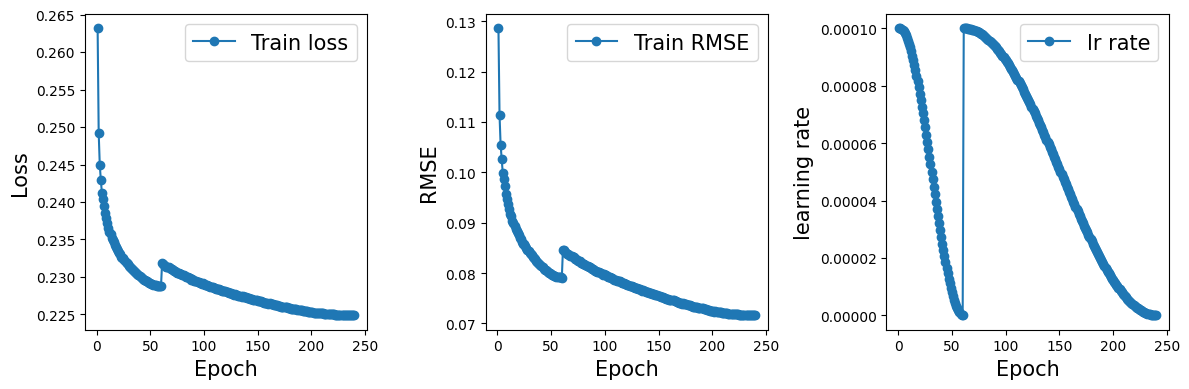

In [19]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 3, 2)
ax.plot(x_arr, hist[1], '-o', label='Train RMSE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('RMSE', size=15)

ax = fig.add_subplot(1, 3, 3)
ax.plot(x_arr, lr_hist, '-o', label='lr rate')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('learning rate', size=15)


plt.tight_layout()
plt.savefig(IMAGE_DIR / f"{FILE_PREFIX}_{learning_rate}.png")
plt.show()

### Test submission

In [20]:
final_test_img_path = data_folder / "images_test_rev1"
final_test_file_list = sorted([str(path) for path in final_test_img_path.glob('*.jpg')])
print(f"Number of test files: {len(final_test_file_list)}")

Number of test files: 79975


In [21]:
class FinalTestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __getitem__(self, index):
        file = self.file_list[index]
        image = Image.open(file)

        if self.transform is not None:
            image = self.transform(image)

        gxy_id = Path(file).stem
        
        return image, gxy_id
    
    def __len__(self):
        return len(self.file_list)

final_test_dataset = FinalTestImageDataset(final_test_file_list, transform)
final_test_dl = DataLoader(final_test_dataset, num_workers=8, persistent_workers=True, batch_size=1000, shuffle=False)

/home/user/cyng/.conda/envs/galaxy_zoo/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
import csv

with open("submission.csv", "w", newline="") as submission_file:
    writer = csv.writer(submission_file)
    writer.writerow([
        "GalaxyID", "Class1.1", "Class1.2", "Class1.3", "Class2.1", "Class2.2", 
        "Class3.1", "Class3.2", "Class4.1", "Class4.2", "Class5.1", "Class5.2", 
        "Class5.3", "Class5.4", "Class6.1", "Class6.2", "Class7.1", "Class7.2", 
        "Class7.3", "Class8.1", "Class8.2", "Class8.3", "Class8.4", "Class8.5", 
        "Class8.6", "Class8.7", "Class9.1", "Class9.2", "Class9.3", "Class10.1", 
        "Class10.2", "Class10.3", "Class11.1", "Class11.2", "Class11.3", "Class11.4", 
        "Class11.5", "Class11.6"
    ])

    print("Getting test results from model...")
    model.eval()
    all_preds_soft_labels = np.zeros((len(final_test_dataset), SUBCLASS_LEN_CUMSUM[-1]))
    gxy_ids = np.zeros((len(final_test_dataset),))
    i = 0
    with torch.no_grad():
        for img_batch, gxy_id_batch in final_test_dl:
            print(f"Progress: {i + 1} / {len(all_preds_soft_labels)}", end="\r")
            img_batch = img_batch.to(device) 
            pred = model(img_batch)
            pred_soft_labels = pred.cpu().numpy()

            if len(pred_soft_labels) == 1000:
                all_preds_soft_labels[i: (i + 1000)] = pred_soft_labels
                gxy_ids[i: (i + 1000)] = gxy_id_batch
                i += 1000
            else:
                all_preds_soft_labels[i:] = pred_soft_labels
                gxy_ids[i: ] = gxy_id_batch
                i += len(pred_soft_labels)
                break
                
    print()
    print("Writing test results to submission file...")
    for i in range(len(all_preds_soft_labels)):
        print(f"Progress: {i + 1} / {len(all_preds_soft_labels)}", end="\r")
        output_list = [int(gxy_ids[i])] + all_preds_soft_labels[i].tolist()
        writer.writerow(output_list)

    print()
    print("Done!")

Getting test results from model...
Progress: 79001 / 79975
Writing test results to submission file...
Progress: 79975 / 79975
Done!


In [40]:
from pytorchsummary import summary

summary(model=model, input_size=(3, 128, 128))

for name, param in model.named_parameters():
    print(f"Parameter: {name}, Mean: {param.data.mean().item()}")

               Layer	Output Shape        	    Kernal Shape    	#params             	#(weights + bias)   	requires_grad
------------------------------------------------------------------------------------------------------------------------------------------------------
            Conv2d-1	[1, 32, 128, 128]   	  [32, 3, 17, 17]   	27776               	(27744 + 32)        	True True 
       BatchNorm2d-2	[1, 32, 128, 128]   	        [32]        	64                  	(32 + 32)           	True True 
              ReLU-3	[1, 32, 128, 128]   	                    	                    	                    	          
 AdaptiveMaxPool2d-4	[1, 32, 1, 1]       	                    	                    	                    	          
 AdaptiveAvgPool2d-5	[1, 32, 1, 1]       	                    	                    	                    	          
           Flatten-6	[1, 32]             	                    	                    	                    	          
            Linear-7	[1, 32]      

[Conv2d(3, 32, kernel_size=(17, 17), stride=(1, 1), padding=(8, 8)), CBAM(
  (channel_attention_module): channel_attention(
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (mlp): Sequential(
      (fc1): Linear(in_features=32, out_features=32, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=32, out_features=32, bias=True)
    )
    (sigmoid): Sigmoid()
  )
  (spatial_attention_module): spatial_attention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (sigmoid): Sigmoid()
  )
)]


100%|█| 1/1 [00:00
100%|█| 1/1 [00:00


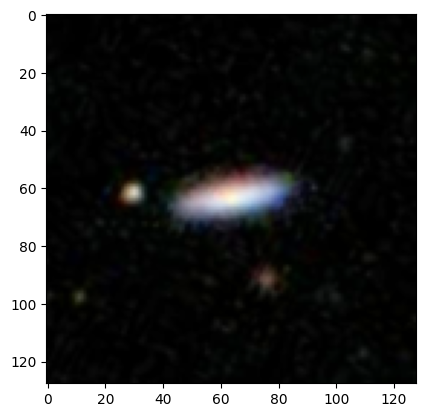

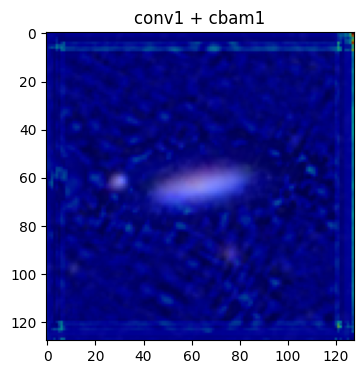

In [39]:
from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.conv1, model.cbam1]
print(target_layers)

cam = AblationCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=transform(Image.open("../data/images_test_rev1/100037.jpg")).unsqueeze(0))

resize = transforms.Resize((128, 128))
img_array = resize(Image.open("../data/images_test_rev1/100037.jpg"))
img_array = np.array(img_array)
img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))
plt.imshow(img_array)
plt.show()
visualization = show_cam_on_image(img_array, grayscale_cam[0], use_rgb=True)
plt.figure(figsize=(4, 4))
plt.imshow(visualization)
plt.title("conv1 + cbam1")
plt.savefig("images/ablationcam1")
plt.show()